In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

# Loading data

In [2]:
# Shenzhen :-
# Some masks are missing so select according to masks
# name of img  is as CHNCXR_0001_0.png
# name of mask is as CHNCXR_0001_0_mask.png

# xtrain is for images
# ytrain for masks

xtrain = [] 
ytrain = []

shape = (512,512)

for name in os.listdir('Tuberculosis-Chest-X-ray-Datasets/Shenzhen-Hospital-CXR-Set/mask'):
    
    img_path  = 'Tuberculosis-Chest-X-ray-Datasets/Shenzhen-Hospital-CXR-Set/CXR_png/' + name[:-9] + '.png'
    mask_path = 'Tuberculosis-Chest-X-ray-Datasets/Shenzhen-Hospital-CXR-Set/mask/' + name
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    
    xtrain.append(cv2.resize(img,shape))
    ytrain.append(cv2.resize(mask,shape))

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

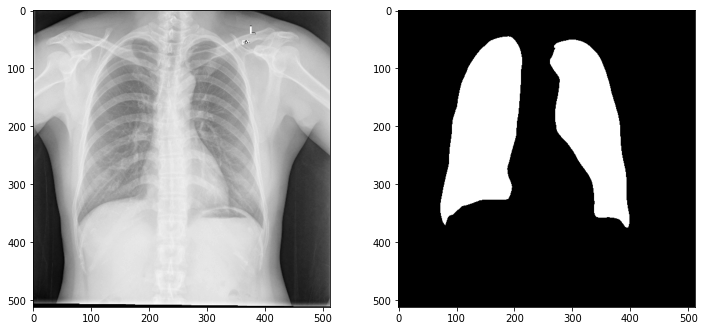

In [45]:
plt.figure(figsize = (12,12))

plt.subplot(2,2,1)
plt.imshow(xtrain[1],cmap = 'gray')
plt.subplot(2,2,2)
plt.imshow(ytrain[1],cmap = 'gray')
plt.show()

In [7]:
# Reshaping so as to get shape from (x,y,z) to (x,y,z,1) that layers want

xtrain = xtrain.reshape((xtrain.shape[0],xtrain.shape[1],xtrain.shape[2],1))
ytrain = ytrain.reshape((ytrain.shape[0],ytrain.shape[1],ytrain.shape[2],1))

In [8]:
xtrain,xtest,ytrain,ytest = train_test_split(xtrain,ytrain,test_size = 0.15)

In [9]:
xtrain = (xtrain - 127.0)/127.0
ytrain = (ytrain > 127).astype(np.float32)
xtest = (xtest - 127.0)/127.0
ytest = (ytest > 127).astype(np.float32)

In [10]:
# This method can be used to flip an image horizontally, to add more data
# arr = np.array([[[1,2],[3,4]],[[5,6],[7,8]]])
# np.concatenate((arr,arr[:,:,::-1]))

xtrain = np.concatenate((xtrain,xtrain[:,:,::-1]))
ytrain = np.concatenate((ytrain,ytrain[:,:,::-1]))

In [11]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape

((962, 512, 512, 1), (962, 512, 512, 1), (85, 512, 512, 1), (85, 512, 512, 1))

# Model building

In [12]:
def conv_block_(x,num_features):
    
    x = layers.Conv2D(num_features,3,padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(num_features,3,padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

In [13]:
def down_sample_(x,num_features):
    
    skip = conv_block_(x,num_features)
    x = layers.MaxPool2D((2,2))(skip)
    
    return x,skip

In [14]:
def up_sample_(x,skip,num_features):
    
    x = layers.Conv2DTranspose(num_features,(2,2),strides = 2,padding = 'same')(x)
    x = layers.concatenate([x,skip])
    x = conv_block_(x,num_features)
    
    return x

In [15]:
def build_model_(input_shape):
    
    skip_list = []
    input_layer = keras.Input(input_shape)
    x = input_layer
    
    x,skip = down_sample_(x,32)    
    x,skip1 = down_sample_(x,64)
    x,skip2 = down_sample_(x,128)
    x,skip3 = down_sample_(x,256)

    x = conv_block_(x,512)
    
    x = up_sample_(x,skip3,256)
    x = up_sample_(x,skip2,128)
    x = up_sample_(x,skip1,64)
    x = up_sample_(x,skip,32)
    
    x = layers.Conv2D(1,1,padding = 'same',activation = 'sigmoid')(x)
        
    return keras.Model(input_layer,x,name = 'unet')

# Building model

In [16]:
model = build_model_((512,512,1))
model.summary()

2022-06-23 19:31:00.921577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 19:31:01.040635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 19:31:01.041440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 19:31:01.042584: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

### Loss function needed

In [17]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)


## Finally, training out model

In [19]:
# xtrain has values from 0 to 255 (make them from -1 to +1)
# ytrain has values from 0 to 255 (make them between 0 to 1)

model.compile(
    loss = [dice_coef_loss],
    optimizer = keras.optimizers.Adam(lr = 0.0005),
    metrics = [dice_coef,'binary_accuracy']
)
history = model.fit(
    xtrain,
    ytrain,
    epochs = 30,
    batch_size = 15,
    validation_split = 0.2
)

2022-06-23 19:33:40.070836: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 806354944 exceeds 10% of free system memory.


Epoch 1/30


2022-06-23 19:33:46.687710: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-23 19:33:46.825223: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-23 19:33:46.892098: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


52/52 [==============================] - 40s 664ms/step - loss: 0.0764 - dice_coef: 0.9234 - binary_accuracy: 0.9735 - val_loss: 0.9372 - val_dice_coef: 0.0628 - val_binary_accuracy: 0.7508
Epoch 2/30
52/52 [==============================] - 32s 625ms/step - loss: 0.0563 - dice_coef: 0.9440 - binary_accuracy: 0.9786 - val_loss: 0.9663 - val_dice_coef: 0.0337 - val_binary_accuracy: 0.7508
Epoch 3/30
52/52 [==============================] - 32s 625ms/step - loss: 0.0497 - dice_coef: 0.9504 - binary_accuracy: 0.9794 - val_loss: 0.9831 - val_dice_coef: 0.0169 - val_binary_accuracy: 0.7508
Epoch 4/30
52/52 [==============================] - 32s 625ms/step - loss: 0.0472 - dice_coef: 0.9520 - binary_accuracy: 0.9793 - val_loss: 0.9914 - val_dice_coef: 0.0086 - val_binary_accuracy: 0.7508
Epoch 5/30
52/52 [==============================] - 32s 625ms/step - loss: 0.0475 - dice_coef: 0.9527 - binary_accuracy: 0.9783 - val_loss: 0.7344 - val_dice_coef: 0.2664 - val_binary_accuracy: 0.7884
Epoch 

In [21]:
model.save('lung_segmentation')
model.save_weights('trained_weights.h5')

2022-06-23 19:50:41.601005: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [22]:
ypred = model.predict(xtrain)
ytestpred = model.predict(xtest)

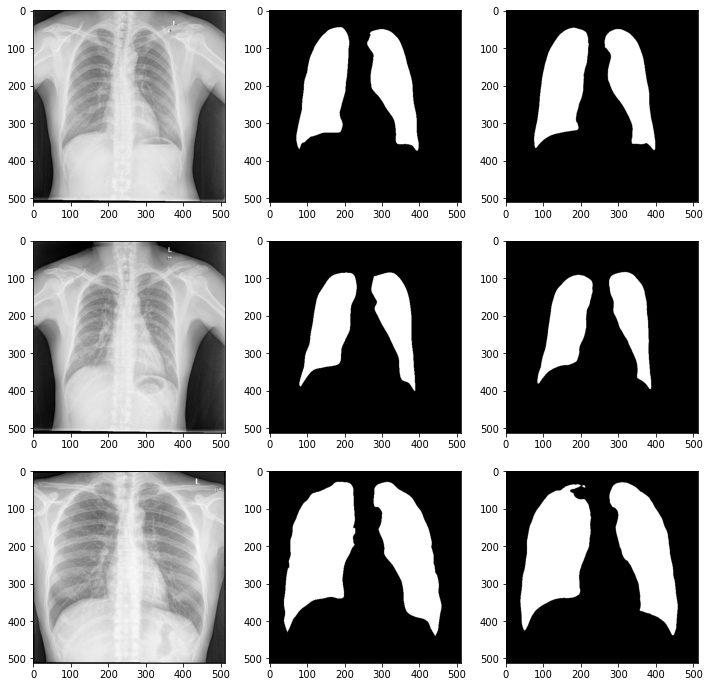

In [36]:
# Comparing generated masks with actual masks

plt.figure(figsize = (12,12))

plt.subplot(3,3,1)
plt.imshow(xtrain[1],cmap = 'gray')
plt.subplot(3,3,2)
plt.imshow(ytrain[1],cmap = 'gray')
plt.subplot(3,3,3)
plt.imshow(ypred[1],cmap = 'gray')

plt.subplot(3,3,4)
plt.imshow(xtest[5],cmap = 'gray')
plt.subplot(3,3,5)
plt.imshow(ytest[5],cmap = 'gray')
plt.subplot(3,3,6)
plt.imshow(ytestpred[5],cmap = 'gray')

plt.subplot(3,3,7)
plt.imshow(xtest[50],cmap = 'gray')
plt.subplot(3,3,8)
plt.imshow(ytest[50],cmap = 'gray')
plt.subplot(3,3,9)
plt.imshow(ytestpred[50],cmap = 'gray')
plt.show()


### Visualizing lung masks created

In [37]:
# to convert 1-channel to 3-channels
image = ((xtrain*127)+127).astype(int)
image = np.concatenate((image,image,image),axis = -1)

In [40]:
mask_real = image.copy()
mask_pred = image.copy()

for i in range(10):
    for row in range(512):
        for col in range(512):
            
            if  ytrain[i][row][col][0] > 0.5 :
                mask_real[i][row][col][0]*=1.5
                mask_real[i][row][col][1] = 50
                mask_real[i][row][col][2] = 0
                    
            if  ypred[i][row][col][0] > 0.5 :
                mask_pred[i][row][col][0]*=1.5
                mask_pred[i][row][col][1] = 0
                mask_pred[i][row][col][2] = 50

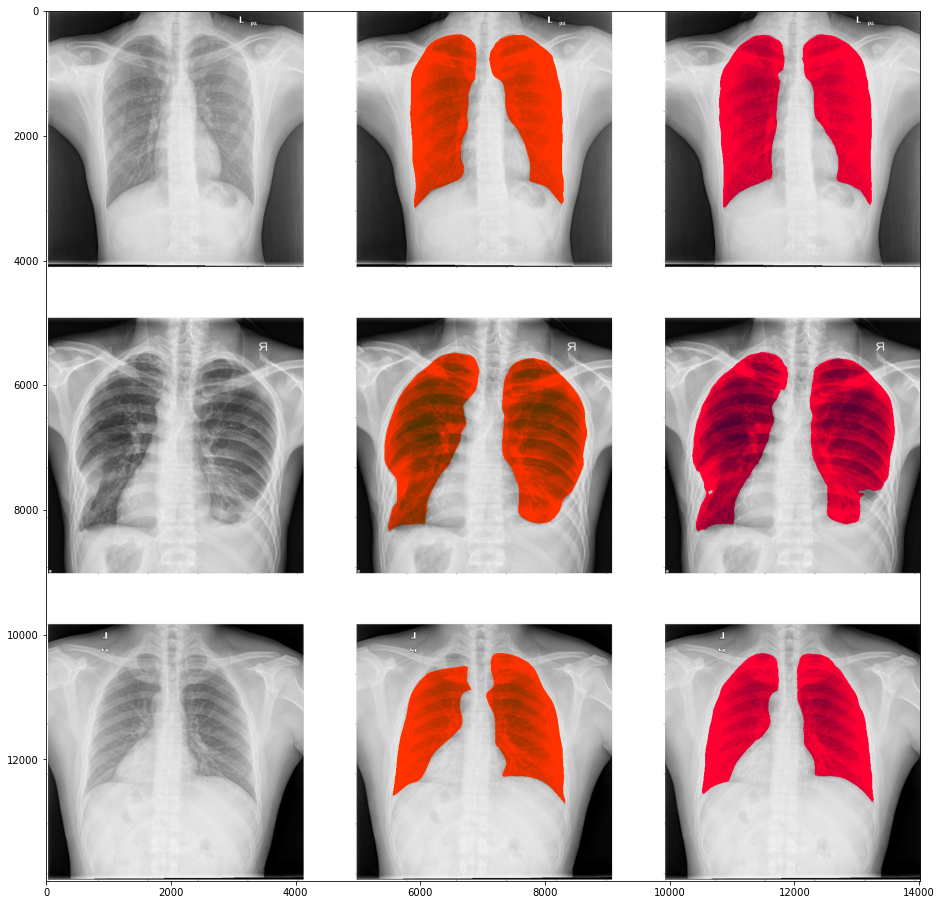

In [49]:
plt.figure(figsize = (251,256))

plt.subplot(3,3,1)
plt.imshow(xtrain[3],cmap = 'gray')
plt.subplot(3,3,2)
plt.imshow(mask_real[3])
plt.subplot(3,3,3)
plt.imshow(mask_pred[3])

plt.subplot(3,3,4)
plt.imshow(xtrain[9],cmap = 'gray')
plt.subplot(3,3,5)
plt.imshow(mask_real[9])
plt.subplot(3,3,6)
plt.imshow(mask_pred[9])

plt.subplot(3,3,7)
plt.imshow(xtrain[15],cmap = 'gray')
plt.subplot(3,3,8)
plt.imshow(mask_real[15])
plt.subplot(3,3,9)
plt.imshow(mask_pred[15])